In [1]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue
from environment import BaseEnvironment
from car_racing import CarRacingEnvironment
from agent import BaseAgent
from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os
import shutil
from plot_script import plot_result

## Action-Value Network

In [2]:
class ActionValueNetwork:

    def __init__(self, network_config):

        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        
        # NN Architecture
        self.layer_sizes = [self.state_dim, self.num_hidden_units, self.num_actions]
        
        # Weights
        self.weights = [dict() for i in range(0, len(self.layer_sizes) - 1)]
        for i in range(0, len(self.layer_sizes) - 1):
            self.weights[i]['W'] = self.init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights[i]['b'] = np.zeros((1, self.layer_sizes[i + 1]))
    
    # Compute action-value
    def get_action_values(self, s):
        """
        Args:
            s (Numpy array): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """
        
        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0) # Relu (Activation)
        
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        q_vals = np.dot(x, W1) + b1

        return q_vals
    
    def get_TD_update(self, s, delta_mat):
        """
        Args:
            s (Numpy array): The state.
            delta_mat (Numpy array): A 2D array of shape (batch_size, num_actions). Each row of delta_mat  
            correspond to one state in the batch. Each row has only one non-zero element 
            which is the TD-error corresponding to the action taken.
        Returns:
            The TD update (Array of dictionaries with gradient times TD errors) for the network's weights
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        dx = (psi > 0).astype(float)

        td_update = [dict() for i in range(len(self.weights))]
         
        v = delta_mat
        td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
        td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
        
        v = np.dot(v, W1.T) * dx
        td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
        td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
                
        return td_update
    
    def init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor
    
    def get_weights(self):
        """
        Returns: 
            A copy of the current weights of this network.
        """
        return deepcopy(self.weights)
    
    def set_weights(self, weights):
        """
        Args: 
            weights (list of dictionaries): Consists of weights that this network will set as its own weights.
        """
        self.weights = deepcopy(weights)

## Section 2: Adam Optimizer

In this assignment, you will use the Adam algorithm for updating the weights of your action-value network. As you may remember from Course 3 Assignment 2, the Adam algorithm is a more advanced variant of stochastic gradient descent (SGD). The Adam algorithm improves the SGD update with two concepts: adaptive vector stepsizes and momentum. It keeps running estimates of the mean and second moment of the updates, denoted by $\mathbf{m}$ and $\mathbf{v}$ respectively:
$$\mathbf{m_t} = \beta_m \mathbf{m_{t-1}} + (1 - \beta_m)g_t \\
\mathbf{v_t} = \beta_v \mathbf{v_{t-1}} + (1 - \beta_v)g^2_t
$$

Here, $\beta_m$ and $\beta_v$ are fixed parameters controlling the linear combinations above and $g_t$ is the update at time $t$ (generally the gradients, but here the TD error times the gradients).

Given that $\mathbf{m}$ and $\mathbf{v}$ are initialized to zero, they are biased toward zero. To get unbiased estimates of the mean and second moment, Adam defines $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ as:
$$ \mathbf{\hat{m}_t} = \frac{\mathbf{m_t}}{1 - \beta_m^t} \\
\mathbf{\hat{v}_t} = \frac{\mathbf{v_t}}{1 - \beta_v^t}
$$

The weights are then updated as follows:
$$ \mathbf{w_t} = \mathbf{w_{t-1}} + \frac{\alpha}{\sqrt{\mathbf{\hat{v}_t}}+\epsilon} \mathbf{\hat{m}_t}
$$

Here, $\alpha$ is the step size parameter and $\epsilon$ is another small parameter to keep the denominator from being zero.

In the cell below, you will implement the `__init__()` and `update_weights()` methods for the Adam algorithm. In `__init__()`, you will initialize `self.m` and `self.v`. In `update_weights()`, you will compute new weights given the input weights and an update $g$ (here `td_errors_times_gradients`) according to the equations above.

In [3]:
class Adam():
 
    def __init__(self, layer_sizes, optimizer_info):
        
        self.layer_sizes = layer_sizes

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")
        
        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(1, len(self.layer_sizes))]
        self.v = [dict() for i in range(1, len(self.layer_sizes))]
        
        for i in range(0, len(self.layer_sizes) - 1):
            # Inizialization
            self.m[i]["W"] = np.zeros((self.layer_sizes[i],self.layer_sizes[i+1]))
            self.m[i]["b"] = np.zeros( (1,self.layer_sizes[i+1]) )
            self.v[i]["W"] = np.zeros((self.layer_sizes[i],self.layer_sizes[i+1]))
            self.v[i]["b"] = np.zeros( (1,self.layer_sizes[i+1]) )
            
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v
    

    def update_weights(self, weights, td_errors_times_gradients):
        """
        Args:
            weights (Array of dictionaries): The weights of the neural network.
            td_errors_times_gradients (Array of dictionaries): The gradient of the 
            action-values with respect to the network's weights times the TD-error
        Returns:
            The updated weights (Array of dictionaries).
        """
        for i in range(len(weights)):
            for param in weights[i].keys():

                self.m[i][param] = (self.beta_m * self.m[i][param]) + (1-self.beta_m) * td_errors_times_gradients[i][param]
                self.v[i][param] = (self.beta_v * self.v[i][param]) + (1-self.beta_v)*(td_errors_times_gradients[i][param]**2)
                m_hat = self.m[i][param] / (1-self.beta_m_product)
                v_hat = self.v[i][param] / (1-self.beta_v_product)
                weight_update = (self.step_size * m_hat) / (v_hat**0.5 + self.epsilon )
  
                weights[i][param] = weights[i][param] + weight_update

        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights

## Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator. 
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.           
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

## Softmax Policy

In [5]:
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """
    
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = action_values / tau
    # Compute the maximum preference across the actions
    max_preference = np.max(preferences, axis=1)

    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting 
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    
    # Compute the numerator, i.e., the exponential of the preference - the max preference.
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    # Compute the denominator, i.e., the sum over the numerator along the actions axis.
    sum_of_exp_preferences = np.sum(exp_preferences,axis=1)
    

    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting 
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    
    # Compute the action probabilities according to the equation in the previous cell.
    action_probs = exp_preferences / reshaped_sum_of_exp_preferences

    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

## Putting the pieces together

In this section, you will combine components from the previous sections to write up an RL-Glue Agent. The main component that you will implement is the action-value network updates with experience sampled from the experience replay buffer.

At time $t$, we have an action-value function represented as a neural network, say $Q_t$. We want to update our action-value function and get a new one we can use at the next timestep. We will get this $Q_{t+1}$ using multiple replay steps that each result in an intermediate action-value function $Q_{t+1}^{i}$ where $i$ indexes which replay step we are at.

In each replay step, we sample a batch of experiences from the replay buffer and compute a minibatch Expected-SARSA update. Across these N replay steps, we will use the current "un-updated" action-value network at time $t$, $Q_t$, for computing the action-values of the next-states. This contrasts using the most recent action-values from the last replay step $Q_{t+1}^{i}$. We make this choice to have targets that are stable across replay steps. Here is the pseudocode for performing the updates:

$$
\begin{align}
& Q_t \leftarrow \text{action-value network at timestep t (current action-value network)}\\
& \text{Initialize } Q_{t+1}^1 \leftarrow Q_t\\
& \text{For } i \text{ in } [1, ..., N] \text{ (i.e. N} \text{  replay steps)}:\\
& \hspace{1cm} s, a, r, t, s'
\leftarrow \text{Sample batch of experiences from experience replay buffer} \\
& \hspace{1cm} \text{Do Expected Sarsa update with } Q_t: Q_{t+1}^{i+1}(s, a) \leftarrow Q_{t+1}^{i}(s, a) + \alpha \cdot \left[r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) - Q_{t+1}^{i}(s, a)\right]\\
& \hspace{1.5cm} \text{ making sure to add the } \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) \text{ for non-terminal transitions only.} \\
& \text{After N replay steps, we set } Q_{t+1}^{N} \text{ as } Q_{t+1} \text{ and have a new } Q_{t+1} \text{for time step } t + 1 \text{ that we will fix in the next set of updates. }
\end{align}
$$

As you can see in the pseudocode, after sampling a batch of experiences, we do many computations. The basic idea however is that we are looking to compute a form of a TD error. In order to so, we can take the following steps:
- compute the action-values for the next states using the action-value network $Q_{t}$,
- compute the policy $\pi(b | s')$ induced by the action-values $Q_{t}$ (using the softmax function you implemented before),
- compute the Expected sarsa targets $r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right)$,
- compute the action-values for the current states using the latest $Q_{t + 1}$, and,
- compute the TD-errors with the Expected Sarsa targets.
 
For the third step above, you can start by computing $\pi(b | s') Q_t(s', b)$ followed by summation to get $\hat{v}_\pi(s') = \left(\sum_{b} \pi(b | s') Q_t(s', b)\right)$. $\hat{v}_\pi(s')$ is an estimate of the value of the next state. Note for terminal next states, $\hat{v}_\pi(s') = 0$. Finally, we add the rewards to the discount times $\hat{v}_\pi(s')$.

You will implement these steps in the `get_td_error()` function below which given a batch of experiences (including states, next_states, actions, rewards, terminals), fixed action-value network (current_q), and action-value network (network), computes the TD error in the form of a 1D array of size batch_size.

In [6]:
### Work Required: Yes. Fill in code in get_td_error (~9 Lines).
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """
    
    # Note: Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # Note that q_next_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    q_next_mat = current_q.get_action_values(next_states)
    ### END CODE HERE
    # your code here
    
    
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # Note that probs_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    probs_mat = softmax(q_next_mat,tau)
    ### END CODE HERE
    # your code here
    
    
    # Compute the estimate of the next state value, v_next_vec.
    # Hint: sum the action-values for the next_states weighted by the policy, probs_mat. Then, multiply by
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    # Note that v_next_vec is a 1D array of shape (batch_size,)
    
    ### START CODE HERE (~3 Lines)
    weighted_next_mat = q_next_mat*probs_mat
    action_values_sum = np.sum(weighted_next_mat,axis=1)
    v_next_vec = action_values_sum*(1-terminals)
    ### END CODE HERE
    # your code here
    
    
    # Compute Expected Sarsa target
    # Note that target_vec is a 1D array of shape (batch_size,)
    
    ### START CODE HERE (~1 Line)
    target_vec = rewards + discount*v_next_vec
    ### END CODE HERE
    # your code here
    
    
    # Compute action values at the current states for all actions using network
    # Note that q_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    q_mat = network.get_action_values(states)
    ### END CODE HERE
    # your code here
    
    
    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # Note that q_vec is a 1D array of shape (batch_size)
    
    ### START CODE HERE (~1 Line)
    q_vec = q_mat[batch_indices,actions]
    ### END CODE HERE
    # your code here
    
    
    # Compute TD errors for actions taken
    # Note that delta_vec is a 1D array of shape (batch_size)
    
    ### START CODE HERE (~1 Line)
    delta_vec = target_vec - q_vec
    ### END CODE HERE
    # your code here
    
    
    return delta_vec

In [7]:
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]

    # Compute TD error using the get_td_error function
    # Note that q_vec is a 1D array of shape (batch_size)
    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)

    # Batch Indices is an array from 0 to the batch_size - 1. 
    batch_indices = np.arange(batch_size)

    # Make a td error matrix of shape (batch_size, num_actions)
    # delta_mat has non-zero value only for actions taken
    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec

    # Pass delta_mat to compute the TD errors times the gradients of the network's weights from back-propagation
    
    ### START CODE HERE
    td_update = network.get_TD_update(states,delta_mat)
    ### END CODE HERE
    # your code here
    
    
    # Pass network.get_weights and the td_update to the optimizer to get updated weights
    ### START CODE HERE
    weights = optimizer.update_weights(network.get_weights(), td_update)
    ### END CODE HERE
    # your code here
    
    
    network.set_weights(weights)

In [8]:
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    # Work Required: No.
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0

    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    # Work Required: No.
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    # Work Required: Yes. Fill in the action selection, replay-buffer update, 
    # weights update using optimize_network, and updating last_state and last_action (~5 lines).
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)

        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments

        # your code here
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network (~1 Line)
                # your code here
                optimize_network(experiences,self.discount,self.optimizer,self.network,current_q,self.tau)
                
        # Update the last state and last action.
        ### START CODE HERE (~2 Lines)
        self.last_state = state
        self.last_action = action
        ### END CODE HERE
        # your code here
        
        
        return action

    # Work Required: Yes. Fill in the replay-buffer update and
    # update of the weights using optimize_network (~2 lines).
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments
        
        # your code here
        self.replay_buffer.append(self.last_state,self.last_action,reward,1,state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                # your code here
                optimize_network(experiences,self.discount,self.optimizer,self.network,current_q,self.tau)
                
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

## Section 6: Run Experiment

Now that you implemented the agent, we can use it to run an experiment on the Lunar Lander problem. We will plot the learning curve of the agent to visualize learning progress. To plot the learning curve, we use the sum of rewards in an episode as the performance measure. We have provided for you the experiment/plot code in the cell below which you can go ahead and run. Note that running the cell below has taken approximately 10 minutes in prior testing.

In [47]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
        # Start from pre trained weights!
        #rl_glue.agent.network.weights = np.load('trained_networks/agent_003.npy', allow_pickle=True)

        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
            #print(episode_reward)

    # Save Results
            save_name = "{}".format(rl_glue.agent.name)
            
            if not os.path.exists('results'):
                os.makedirs('results')
            #np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
            np.save("results/sum_reward_{}".format(save_name), agent_sum_reward[:,:episode])
            shutil.make_archive('results', 'zip', 'results')

    return rl_glue # To get the agent

# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 300,
    "timeout" : 1000, # timestep limit (set to 500 as default)
}

# Environment parameters
environment_parameters = {}

current_env = CarRacingEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 6, # State Dimension (number of inputs)
        'num_hidden_units': 16, #
        'num_actions': 5 # Action Space (number of outputs)
    },
    'optimizer_config': {
        'step_size': 1e-4, # 1e-3
        'beta_m': 0.9,
        'beta_v': 0.999, # 0.999
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 2,
    'gamma': 0.989,
    'tau': 0.002 # 0.001
}

current_agent = Agent

# run experiment
rl_glue_return = run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|██████████| 300/300 [1:06:27<00:00, 13.29s/it]


Run the cell below to see the comparison between the agent that you implemented and a random agent for the one run and 300 episodes. Note that the `plot_result()` function smoothes the learning curve by applying a sliding window on the performance measure. 

In [48]:
# Save/Load agent
np.save('trained_networks/agent_004_albon.npy', rl_glue_return.agent.network.weights)
trained_weights = np.load('trained_networks/agent_004_albon.npy', allow_pickle=True)

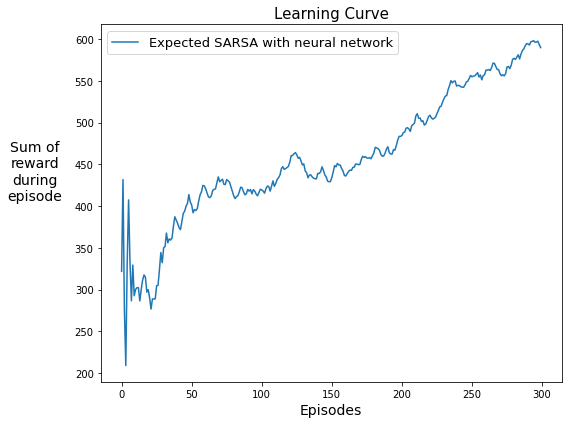

In [49]:
plot_result(["expected_sarsa_agent"])

# Test Car Racing

In [ ]:
rl_glue_return.environment.env_init()
rl_glue_return.environment.rand_generator = np.random.RandomState(0)

In [ ]:
# Start Environment
observation = rl_glue_return.environment.env_start()
transformed_obs = observation = rl_glue_return.transform_state(observation)
transformed_obs

In [ ]:
# Select Action
action = rl_glue_return.agent.policy(transformed_obs)
print(f"Action: {action}")

# Do Action
reward, observation, is_terminal = rl_glue_return.environment.env_step(action)
transformed_obs = transformed_obs = observation = rl_glue_return.transform_state(observation)
print(f"Transformed State: {transformed_obs}")

if is_terminal:
    print("Terminal State")
    observation = rl_glue_return.environment.env_start()

rl_glue_return.environment.env.render();


## Let it run!

In [54]:
import time

# Start Environment
rl_glue_return.environment.env_init()
rl_glue_return.environment.rand_generator = np.random.RandomState(3) # I like 2, 9, 4, 21

# Set tau
rl_glue_return.agent.tau = 0.00001
time_steps = 1000

observation = rl_glue_return.environment.env_start()
transformed_obs = observation = rl_glue_return.transform_state(observation)
episode_reward = 0

for i in tqdm(range(time_steps)):
    
    # Select Action
    action = rl_glue_return.agent.policy(transformed_obs)

    # Do Action
    reward, observation, is_terminal = rl_glue_return.environment.env_step(action)
    transformed_obs = transformed_obs = observation = rl_glue_return.transform_state(observation)

    episode_reward += reward

    if is_terminal:
        message = "Terminal State: Max number of steps completed."
        if i != time_steps-1:
            message = "Terminal State: All tiles visited!"
        print(message)
        print(f'Reward: {episode_reward}')
        break
        observation = rl_glue_return.environment.env_start()

    # Render
    rl_glue_return.environment.env.render();

    if i == 0:
        time.sleep(2)

 78%|███████▊  | 782/1000 [00:19<00:05, 40.52it/s]

Terminal State: All tiles visited!
Reward: 921.6999999999882
